In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn

In [2]:
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [46]:
df = pd.read_csv('data_area_2.csv')
df

,Label,RSSI_1,proximity_1,accuracy_1,RSSI_2,proximity_2,accuracy_2,RSSI_3,proximity_3,accuracy_3,RSSI_4,proximity_4,accuracy_4
0,A,-70,far,13.851972,-58,far,6.287733,-61,far,8.067809,-65,far,7.121443
1,A,-71,far,14.259079,-60,far,5.878623,-61,far,7.542129,-63,far,7.071776
2,A,-69,far,14.302249,-60,far,5.603389,-63,far,7.435441,-60,far,6.549222
3,A,-69,far,14.341001,-62,far,5.669041,-65,far,7.595746,-62,far,6.458476
4,A,-69,far,14.375774,-72,far,6.493668,-62,far,7.327017,-63,far,6.509904
...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,C,-66,far,7.082790,-71,far,18.131115,-68,far,17.088874,-73,far,22.150106
254,C,-66,far,8.452925,-69,far,18.347707,-79,far,19.353247,-78,far,24.354757
255,C,-64,far,8.342343,-72,far,18.672650,-80,far,20.681886,-77,far,25.227219
256,C,-67,far,8.669814,-68,far,17.781409,-78,far,21.814865,-74,far,25.428526


In [47]:
dt = df.Label.values

In [51]:
len(np.where(dt=="A")[0]), len(np.where(dt=="B")[0]), len(np.where(dt=="C")[0])

(89, 83, 86)

In [5]:
proximity_1_dummies = pd.get_dummies(df.proximity_1,prefix='proximity_1',dtype=int)
proximity_2_dummies = pd.get_dummies(df.proximity_2,prefix='proximity_2',dtype=int)
proximity_3_dummies = pd.get_dummies(df.proximity_3,prefix='proximity_3',dtype=int)
proximity_4_dummies = pd.get_dummies(df.proximity_4,prefix='proximity_4',dtype=int)
df = pd.concat([df, proximity_1_dummies,proximity_2_dummies, proximity_3_dummies, proximity_4_dummies], axis=1)
df

,Label,RSSI_1,proximity_1,accuracy_1,RSSI_2,proximity_2,accuracy_2,RSSI_3,proximity_3,accuracy_3,...,proximity_1_far,proximity_1_near,proximity_1_unknow,proximity_2_far,proximity_2_near,proximity_3_far,proximity_3_near,proximity_4_far,proximity_4_near,proximity_4_unknow
0,A,-70,far,13.851972,-58,far,6.287733,-61,far,8.067809,...,1,0,0,1,0,1,0,1,0,0
1,A,-71,far,14.259079,-60,far,5.878623,-61,far,7.542129,...,1,0,0,1,0,1,0,1,0,0
2,A,-69,far,14.302249,-60,far,5.603389,-63,far,7.435441,...,1,0,0,1,0,1,0,1,0,0
3,A,-69,far,14.341001,-62,far,5.669041,-65,far,7.595746,...,1,0,0,1,0,1,0,1,0,0
4,A,-69,far,14.375774,-72,far,6.493668,-62,far,7.327017,...,1,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,C,-66,far,7.082790,-71,far,18.131115,-68,far,17.088874,...,1,0,0,1,0,1,0,1,0,0
254,C,-66,far,8.452925,-69,far,18.347707,-79,far,19.353247,...,1,0,0,1,0,1,0,1,0,0
255,C,-64,far,8.342343,-72,far,18.672650,-80,far,20.681886,...,1,0,0,1,0,1,0,1,0,0
256,C,-67,far,8.669814,-68,far,17.781409,-78,far,21.814865,...,1,0,0,1,0,1,0,1,0,0


In [6]:
#becauce proximity does not conatin near
'''df['proximity_2_far'] = 1
df['proximity_2_near'] = 0
df'''

"df['proximity_2_far'] = 1\ndf['proximity_2_near'] = 0\ndf"

In [7]:
df = df.drop(['proximity_1', 'proximity_2', 'proximity_3', 'proximity_4'], axis=1)
df

,Label,RSSI_1,accuracy_1,RSSI_2,accuracy_2,RSSI_3,accuracy_3,RSSI_4,accuracy_4,proximity_1_far,proximity_1_near,proximity_1_unknow,proximity_2_far,proximity_2_near,proximity_3_far,proximity_3_near,proximity_4_far,proximity_4_near,proximity_4_unknow
0,A,-70,13.851972,-58,6.287733,-61,8.067809,-65,7.121443,1,0,0,1,0,1,0,1,0,0
1,A,-71,14.259079,-60,5.878623,-61,7.542129,-63,7.071776,1,0,0,1,0,1,0,1,0,0
2,A,-69,14.302249,-60,5.603389,-63,7.435441,-60,6.549222,1,0,0,1,0,1,0,1,0,0
3,A,-69,14.341001,-62,5.669041,-65,7.595746,-62,6.458476,1,0,0,1,0,1,0,1,0,0
4,A,-69,14.375774,-72,6.493668,-62,7.327017,-63,6.509904,1,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,C,-66,7.082790,-71,18.131115,-68,17.088874,-73,22.150106,1,0,0,1,0,1,0,1,0,0
254,C,-66,8.452925,-69,18.347707,-79,19.353247,-78,24.354757,1,0,0,1,0,1,0,1,0,0
255,C,-64,8.342343,-72,18.672650,-80,20.681886,-77,25.227219,1,0,0,1,0,1,0,1,0,0
256,C,-67,8.669814,-68,17.781409,-78,21.814865,-74,25.428526,1,0,0,1,0,1,0,1,0,0


In [8]:
df = df.drop(['proximity_1_unknow', 'proximity_4_unknow'], axis=1)
df

,Label,RSSI_1,accuracy_1,RSSI_2,accuracy_2,RSSI_3,accuracy_3,RSSI_4,accuracy_4,proximity_1_far,proximity_1_near,proximity_2_far,proximity_2_near,proximity_3_far,proximity_3_near,proximity_4_far,proximity_4_near
0,A,-70,13.851972,-58,6.287733,-61,8.067809,-65,7.121443,1,0,1,0,1,0,1,0
1,A,-71,14.259079,-60,5.878623,-61,7.542129,-63,7.071776,1,0,1,0,1,0,1,0
2,A,-69,14.302249,-60,5.603389,-63,7.435441,-60,6.549222,1,0,1,0,1,0,1,0
3,A,-69,14.341001,-62,5.669041,-65,7.595746,-62,6.458476,1,0,1,0,1,0,1,0
4,A,-69,14.375774,-72,6.493668,-62,7.327017,-63,6.509904,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,C,-66,7.082790,-71,18.131115,-68,17.088874,-73,22.150106,1,0,1,0,1,0,1,0
254,C,-66,8.452925,-69,18.347707,-79,19.353247,-78,24.354757,1,0,1,0,1,0,1,0
255,C,-64,8.342343,-72,18.672650,-80,20.681886,-77,25.227219,1,0,1,0,1,0,1,0
256,C,-67,8.669814,-68,17.781409,-78,21.814865,-74,25.428526,1,0,1,0,1,0,1,0


In [9]:
label = []
for area in df.Label.values:
    if area == 'A':
        label.append(0)
    elif area == 'B':
        label.append(1)
    else:
        label.append(2)
label = np.asarray(label)
label.shape

(258,)

In [10]:
df.columns[1:]

Index(['RSSI_1', 'accuracy_1', 'RSSI_2', 'accuracy_2', 'RSSI_3', 'accuracy_3',
       'RSSI_4', 'accuracy_4', 'proximity_1_far', 'proximity_1_near',
       'proximity_2_far', 'proximity_2_near', 'proximity_3_far',
       'proximity_3_near', 'proximity_4_far', 'proximity_4_near'],
      dtype='object')

In [11]:
features = df.loc[:,df.columns[1:]]
#features = essentia_df.loc[:,top_features]
features = np.asarray(features)
features.shape

(258, 16)

In [12]:
train_features, test_features, train_labels, test_labels = train_test_split(features, label, test_size=0.2, random_state=42)
train_features.shape, test_features.shape,  train_labels.shape, test_labels.shape

((206, 16), (52, 16), (206,), (52,))

In [13]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, features, label):
      self.features = features
      self.labels = label
    def __getitem__(self, index):
      features = self.features[index]    
      label = self.labels[index]
      return features, label
    def __len__(self):
      return len(self.features)


In [14]:
scaler = StandardScaler().fit(train_features)
train_feature = scaler.transform(train_features)

In [15]:
print(scaler.mean_)

[-6.52087379e+01  1.17634529e+01 -6.38786408e+01  8.40177676e+00
 -6.43106796e+01  8.96885582e+00 -6.75485437e+01  1.38230567e+01
  9.22330097e-01  6.31067961e-02  9.66019417e-01  3.39805825e-02
  9.41747573e-01  5.82524272e-02  9.75728155e-01  1.94174757e-02]


In [16]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()

        self.linear1 = nn.Sequential(
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU()
        )
        self.softmax = nn.LogSoftmax()
        #self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(8,3)
    def forward(self, features):   
        '''for i in range(len(scaler.var_)):
            features[:,i] = (features[:,i] - scaler.mean_[i]) / scaler.var_[i]'''
        #outputs = self.bn(features)  
        outputs = self.linear1(features)
        #outputs = self.dropout(outputs)
        outputs = self.linear2(outputs)

        return outputs


In [17]:
def train(train_dataloader, val_dataloader, num_epochs = 10, validation = True, save_file = 'area', train_batch_size = 32, learning_rate = 5e-5):
    history = dict()
    train_history_loss = []
    train_history_acc = []
    val_history_loss = []
    val_history_acc = []
    model = MLP()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = torch.nn.CrossEntropyLoss()
    best_val_loss = np.inf
    best_val_accuracy = 0
    for epoch in range(num_epochs):
        total_loss = 0
        train_loss = 0
        batch_id = 0
        correct = 0
        print(f"Epoch: {epoch + 1}",'training')
        for batch in train_dataloader:
            model.train()
            features = batch[0].to(device)
            features = features.to(torch.float32)
            labels = batch[1].type(torch.LongTensor).to(device)
            outputs = model(
                features = features
            )
            #print(outputs,labels)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_loss += loss.item()
            _,predict_label = torch.max(outputs,1)
            correct += (predict_label==labels).sum()
            print('batch:', batch_id, '/',str(len(train_dataloader)), 'loss:', loss.item(), end='\r')
            batch_id += 1
        average_loss = total_loss / len(train_dataloader)
        train_history_loss.append(average_loss)
        train_history_acc.append(correct.item()/((len(train_dataloader) - 1) * train_batch_size + len(labels)))
        print(f"Loss: {average_loss:.4f}", 'accuracy:', correct.item()/((len(train_dataloader) - 1) * train_batch_size + len(labels)))
        if validation:
            print('validation')
            model.eval()
            prediction = []
            ans = []
            val_loss = 0.0
            batch_id = 0
            correct = 0
            with torch.no_grad(): 
                for batch in val_dataloader:
                    features = batch[0].to(device)
                    features = features.to(torch.float32)
                    #labels = batch['labels'].clone().detach().to(device)
                    labels = batch[1].type(torch.LongTensor).to(device)
                    output = model( 
                        features = features
                    )
                    loss = loss_function(output, labels.to(device))
                    val_loss += loss.item()
                    _,predict_label = torch.max(output,1)
                    correct += (predict_label==labels).sum()  
                    prediction.append(predict_label.cpu().item())
                    ans.append(labels.cpu().item())
                    print('batch:', batch_id, '/',str(len(val_dataloader)), 'loss:', loss.item(), end='\r')
                    batch_id += 1
            val_loss /= len(val_dataloader)
            val_accuracy = correct.item() / len(val_dataloader)
            val_history_loss.append(val_loss)
            val_history_acc.append(val_accuracy)
            print('loss:', val_loss)
            print('accuracy:',val_accuracy)
            print('f1 score:', f1_score(ans, prediction, average='macro'))
            #if val_monitor == 'loss':
            if val_loss <= best_val_loss:
                best_val_loss = val_loss
                if not os.path.isdir(save_file):
                    os.mkdir(save_file)
                if not os.path.isdir(save_file):
                    os.mkdir(save_file)
                torch.save(model.state_dict(), save_file + '/model_best_loss' + '.pt')
            if val_accuracy >= best_val_accuracy:
                best_val_accuracy = val_accuracy
                if not os.path.isdir(save_file):
                    os.mkdir(save_file)
                if not os.path.isdir(save_file):
                    os.mkdir(save_file)
                #model.save_pretrained(save_file + '/model_best')
                torch.save(model.state_dict(), save_file + '/model_best_acc' + '.pt')
        else:
            if not os.path.isdir(save_file):
                    os.mkdir(save_file)
            if not os.path.isdir(save_file):
                os.mkdir(save_file)
                          
    if not os.path.isdir(save_file):
        os.mkdir(save_file)
    if not os.path.isdir(save_file):
        os.mkdir(save_file)
    torch.save(model.state_dict(), save_file + '/model_final.pt')
    history['train_loss'] = train_history_loss
    history['train_accuracy'] = train_history_acc
    history['val_loss'] = val_history_loss
    history['val_accuracy'] = val_history_acc
    return history
def test(test_dataloader, load_best = 'loss', load_file = 'area'):
    print('testing')
    if load_best == 'loss':
        model = MLP().to(device)
        model.load_state_dict(torch.load(load_file + "/model_best_loss"+ '.pt'))
    elif load_best == 'accuracy':
        model = MLP().to(device)
        model.load_state_dict(torch.load(load_file + "/model_best_loss"+ '.pt'))
    else:
        #model = BertForSequenceClassification.from_pretrained(load_file + "/model5").to(device)
        model = MLP().to(device)
        model.load_state_dict(torch.load(load_file + "/model_best_loss"+ '.pt'))
    model.eval()
    prediction = []
    ans = []
    batch_id = 0
    correct = 0
    with torch.no_grad(): 
        for batch in test_dataloader:
            features = batch[0].to(device)
            features = features.to(torch.float32)
            #labels = torch.tensor(batch['labels'])
            labels = batch[1].type(torch.LongTensor).to(device)
            output = model(
                features = features
            )
            _,predict_label = torch.max(output,1)
            correct += (predict_label==labels.to(device)).sum()
            prediction.append(predict_label.cpu().item())
            ans.append(labels.cpu().item())
            batch_id += 1
            print('batch:', batch_id, end='\r')
    accuracy = correct.item() / len(test_dataloader)
    f1 = f1_score(ans, prediction, average=None)
    prec_recall = precision_recall_fscore_support(ans, prediction)
    conf_m = confusion_matrix(prediction,ans)
    return accuracy, f1, prec_recall,  conf_m

In [18]:
batch_size = 4
epochs = 100
learning_rate = 1e-4

In [19]:
from torch.utils.data import DataLoader, WeightedRandomSampler

from sklearn.utils import class_weight
train_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(train_labels), y=train_labels)
weight_sp = []
for i in train_labels:
    if i == 0:
        weight_sp.append(train_weights[0])
    elif i == 1:
        weight_sp.append(train_weights[1])
    else:
        weight_sp.append(train_weights[2])

In [20]:
scaler = StandardScaler().fit(train_features)
train_feature = scaler.transform(train_features)
#train_feature, val_feature, train_label, val_label = train_test_split(train_features, train_labels, test_size=0.1, random_state=42)
#train_feature, val_feature, train_label, val_label = train_test_split(train_feature, train_labels, test_size=0.1, random_state=42)
train_feature, val_feature, train_label, val_label, train_sp, val_sp = train_test_split(train_feature, train_labels, weight_sp, test_size=0.1, random_state=42)
train_dataset = TrainDataset(features=train_feature, label = train_label)
sampler = WeightedRandomSampler(train_sp, len(train_sp))
train_dataloader =  DataLoader(train_dataset,batch_size=batch_size,shuffle=False, sampler = sampler)
train_dataloader =  DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

val_dataset = TrainDataset(features=val_feature, label = val_label)
val_dataloader =  DataLoader(val_dataset,batch_size=1,shuffle=False)
#test_choi = StandardScaler().fit_transform(features[test])


history = train(train_dataloader, val_dataloader,num_epochs=epochs, train_batch_size = batch_size, learning_rate=learning_rate)

Epoch: 1 training
Loss: 1.1116 accuracy: 0.34054054054054056
validation
loss: 1.1061208588736398422917842864996
accuracy: 0.42857142857142855
f1 score: 0.19999999999999998
Epoch: 2 training
Loss: 1.1060 accuracy: 0.34054054054054056
validation
loss: 1.1001353632836115435322761535645
accuracy: 0.42857142857142855
f1 score: 0.19999999999999998
Epoch: 3 training
Loss: 1.1004 accuracy: 0.34054054054054056
validation
loss: 1.0941459224337624463818550109863
accuracy: 0.42857142857142855
f1 score: 0.19999999999999998
Epoch: 4 training
Loss: 1.0948 accuracy: 0.34054054054054056
validation
loss: 1.0883836547533672491135358810425
accuracy: 0.42857142857142855
f1 score: 0.19999999999999998
Epoch: 5 training
Loss: 1.0893 accuracy: 0.34054054054054056
validation
loss: 1.0825498217628116517076492309577
accuracy: 0.42857142857142855
f1 score: 0.19999999999999998
Epoch: 6 training
Loss: 1.0838 accuracy: 0.34054054054054056
validation
loss: 1.0766090665544783544579267501838
accuracy: 0.4285714285714285

In [21]:
test_feature = scaler.transform(test_features)
test_dataset = TrainDataset(features=test_feature, label = test_labels)
test_dataloader =  DataLoader(test_dataset,batch_size=1,shuffle=False)

accuracy, f1, prec_recall, confusion_m = test(test_dataloader, load_best='acc')
print("test accuracy:",accuracy,"f1 score:",f1)
print(confusion_m)

testing
test accuracy: 0.9423076923076923 f1 score: [0.95454545 0.90322581 0.96551724]
[[21  2  0]
 [ 0 14  0]
 [ 0  1 14]]


In [22]:
accuracy, f1, prec_recall, confusion_m = test(test_dataloader, load_best='final')
print("test accuracy:",accuracy,"f1 score:",f1)
print(confusion_m)

testing
test accuracy: 0.9423076923076923 f1 score: [0.95454545 0.90322581 0.96551724]
[[21  2  0]
 [ 0 14  0]
 [ 0  1 14]]


In [23]:
print(scaler.mean_)

[-6.52087379e+01  1.17634529e+01 -6.38786408e+01  8.40177676e+00
 -6.43106796e+01  8.96885582e+00 -6.75485437e+01  1.38230567e+01
  9.22330097e-01  6.31067961e-02  9.66019417e-01  3.39805825e-02
  9.41747573e-01  5.82524272e-02  9.75728155e-01  1.94174757e-02]


In [24]:
print(scaler.var_)

[9.96894382e+01 5.07900083e+01 3.28153690e+01 1.71800580e+01
 3.74374588e+01 2.09475039e+01 5.73156047e+01 4.69009149e+01
 7.16372891e-02 5.91243284e-02 3.28259025e-02 3.28259025e-02
 5.48590819e-02 5.48590819e-02 2.36827222e-02 1.90404374e-02]


Text(0.5, 1.0, 'loss history')

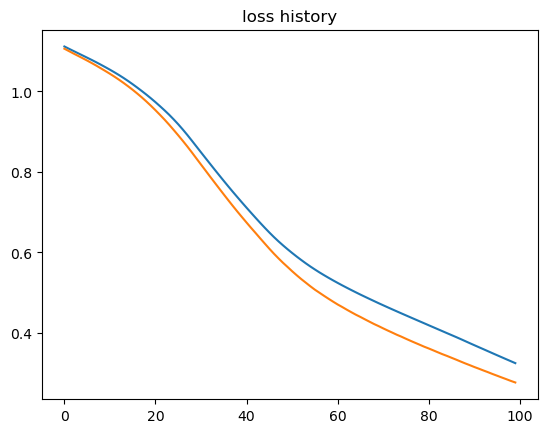

In [25]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('loss history')

Text(0.5, 1.0, 'accuracy history')

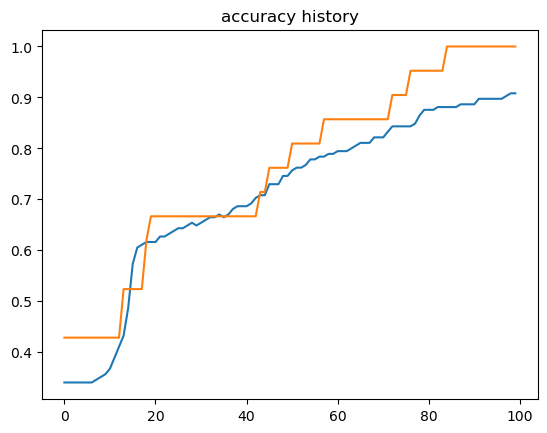

In [26]:
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.title('accuracy history')

In [27]:
import coremltools as ct
import onnx

In [44]:
model = MLP()
model.load_state_dict(torch.load('area/model_best_loss.pt'))
dummy_input = torch.randn(1,16)
torch.onnx.export(model.cpu(), dummy_input, "model_a.onnx", input_names=["input"], output_names=["output"])
onnx_path = 'model_a.onnx'
ml_model = ct.converters.onnx.convert(model=onnx_path)
ml_model.save("model_area.mlmodel")

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

1/5: Converting Node Type Gemm
2/5: Converting Node Type Relu
3/5: Converting Node Type Gemm
4/5: Converting Node Type Relu
5/5: Converting Node Type Gemm
Translation to CoreML spec completed. Now compiling the CoreML model.
Model Compilation done.


In [45]:
for name, param in model.named_parameters():
    print(name, param)

linear1.0.weight Parameter containing:
tensor([[-0.0184,  0.4811, -0.2804,  0.2753,  0.0270, -0.1509,  0.3156, -0.4992,
         -0.1103, -0.4165,  0.1791, -0.2403,  0.2271, -0.3347, -0.0216, -0.0939],
        [-0.0238, -0.1248, -0.0558, -0.2458, -0.0453, -0.0135,  0.0234,  0.0968,
          0.0500, -0.0658,  0.1558, -0.0426, -0.0486, -0.0632, -0.1930,  0.2597],
        [ 0.2405,  0.0599,  0.1062, -0.0947, -0.0244, -0.0127,  0.0119, -0.1327,
         -0.2456, -0.1880, -0.1669, -0.1629, -0.0763, -0.2277, -0.1276,  0.1569],
        [-0.1372,  0.1740, -0.0049,  0.2824,  0.0446,  0.1892,  0.2385, -0.4542,
          0.2906, -0.0885,  0.1699, -0.3644,  0.3138, -0.0619, -0.0868,  0.0525],
        [-0.1020,  0.1135,  0.0221, -0.2189,  0.0224, -0.1825, -0.2134,  0.2009,
          0.1802, -0.2133,  0.1003,  0.0942, -0.0641,  0.1453, -0.0466,  0.0463],
        [ 0.1398, -0.5111, -0.1318,  0.1304, -0.1797,  0.3363, -0.1012,  0.1127,
          0.1829, -0.0414,  0.2419,  0.0955, -0.1623,  0.2464, -0

In [29]:
model = MLP()

model.load_state_dict(torch.load('area/model_best_loss.pt'))

model.eval()

# 输入张量示例
example_input = torch.rand(1, 16)

# 将模型转换为 TorchScript 格式
traced_model = torch.jit.trace(model, example_input)